### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp

### Load Datasets & Data Preprocessing

#### Description of features
- **WDIR**: Wind direction
- **u**: Wind speed (m/s)
- **uSq**: $u^2$
- **e_uSq**: East component of $u^2$
- **n_uSq**: North component of $u^2$
- $Z_2 = u\sqrt{F}$
- $Z_3 = F$
- $Z_4 = \frac{F^{3/2}}{u}$

#### Description of target
- **H**: Significant wave height (ft)

In [2]:
wind_cols = ['u','uSq','e_uSq','n_uSq','Z2','Z3','Z4']

# Load datasets
df = pd.read_csv('WLIS_data.csv')
df = df.rename(columns={'WSPD':'u', 'Fetch':'Z3'})
df['TmStamp'] = pd.to_datetime(df['TmStamp'], format='mixed')
df.set_index('TmStamp', inplace=True)

# Add squared terms (uSq)
df['uSq'] = df['u']**2

# Add east and north components (e_uSq, n_uSq)
alpha = -13
df['rad'] = np.pi/180 * ((alpha + 630 - df['WDIR']) % 360)
df['e_uSq'] = df['uSq'] * np.cos(df['rad'])
df['n_uSq'] = df['uSq'] * np.sin(df['rad'])

# Add interaction terms (Z2, Z4)
df['Z2'] = np.sqrt(df['Z3']) * df['u']
df['Z4'] = (df['Z3']**1.5) / df['u']

df = df[['H'] + wind_cols]
df.head()

,H,u,uSq,e_uSq,n_uSq,Z2,Z3,Z4
TmStamp,,,,,,,,
2004-11-01 00:00:00,3.249133,11.800000,139.240000,63.213637,-124.063748,1058.500122,8046.70,61170.877123
2004-11-01 01:00:00,3.249133,2.100475,4.411995,3.523576,2.655205,188.419736,8046.70,343644.366591
2004-11-01 02:00:00,1.960359,9.300000,86.490000,4.526537,86.371468,646.200781,4828.02,36072.034875
2004-11-01 03:00:00,2.001249,6.651761,44.245923,35.336366,26.627861,596.685572,8046.70,108515.077246
2004-11-01 04:00:00,3.254957,4.455085,19.847783,14.515749,-13.536155,399.636276,8046.70,162020.779306


### Distribution of Features & Target

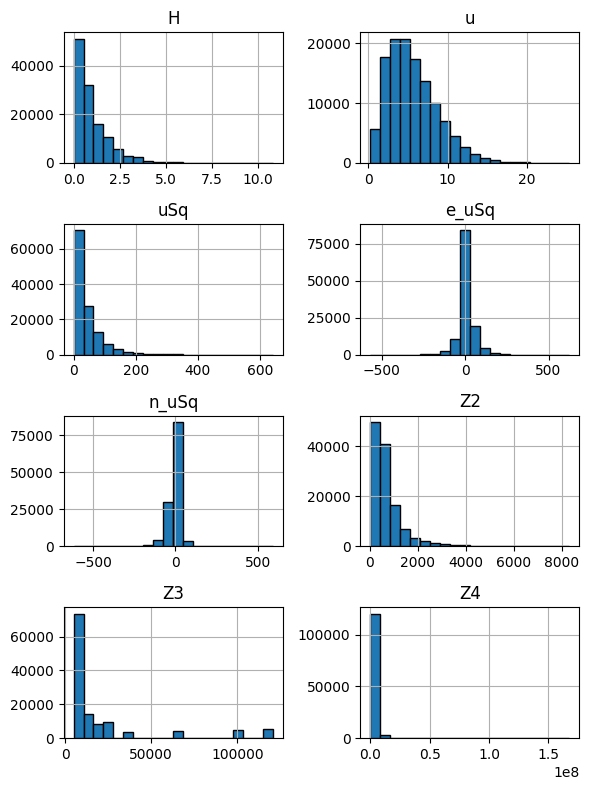

In [3]:
plt.figure(figsize=(6, 8))

# Numerical columns
num_cols = df.columns

for i, col in enumerate(num_cols, start=1):
    plt.subplot((len(num_cols)+1)//2, 2, i)
    df[col].hist(bins=20, edgecolor='black')
    plt.title(f"{col}")

plt.tight_layout()
plt.show()

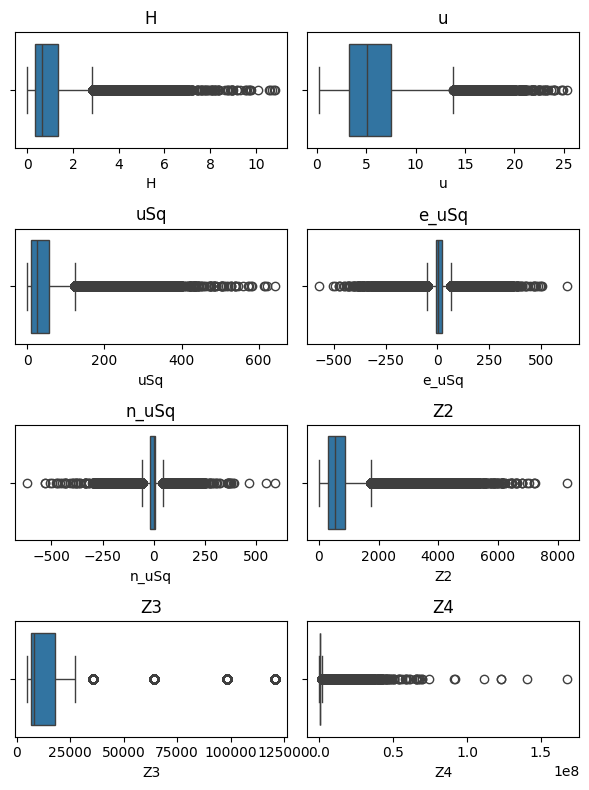

In [4]:
plt.figure(figsize=(6, 8))

# Numerical columns
num_cols = df.columns

for i, col in enumerate(num_cols, start=1):
    plt.subplot((len(num_cols)+1)//2, 2, i)
    sns.boxplot(data=df, x=col)
    plt.title(f"{col}")

plt.tight_layout()
plt.show()

### Correlation Analysis

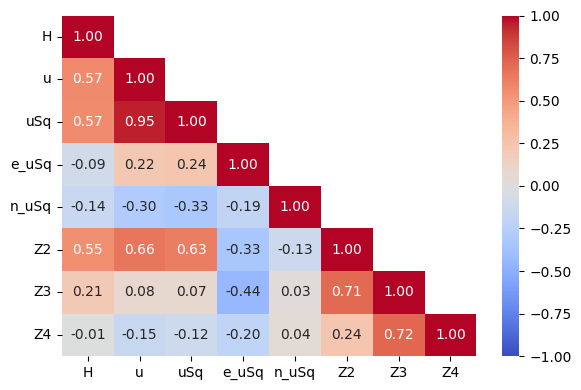

In [5]:
df_corr = df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(df_corr, vmin=-1, vmax=1, center=0, fmt='.2f', annot=True, 
            cmap='coolwarm', mask=np.triu(np.ones_like(df_corr), 1))

plt.tight_layout()
plt.show()

### Kolmogorov-Smirnov (KS) Test

- **Two-sample KS test**: To compare the distributions of a feature between the training set and the test set
- **Null hypothesis**: There is no significant difference between the distributions of two datasets.

#### Comparison of feature distributions between the training, validation, and test sets

In [6]:
# Train-Test split
# df_val: [2008-11-01 00:00:00 ~ 2009-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_train = df[(df.index < split1) | (df.index > split2)]
df_val = df[(df.index > split2) & (df.index < split3)]
df_test = df[(df.index > split1) & (df.index < split2)]

# Data normalization
scaler = MinMaxScaler()
df_train_T = scaler.fit_transform(df_train)
df_val_T = scaler.transform(df_val)
df_test_T = scaler.transform(df_test)
df_train_T = pd.DataFrame(df_train_T, columns=df.columns)
df_val_T = pd.DataFrame(df_val_T, columns=df.columns)
df_test_T = pd.DataFrame(df_test_T, columns=df.columns)

# KS test
results = []
for col in df.columns:
    stat1, p1 = ks_2samp(df_train_T[col], df_test_T[col])
    stat2, p2 = ks_2samp(df_val_T[col], df_test_T[col])
    results.append((col, stat1, p1, stat2, p2))

ks_df = pd.DataFrame(results, columns=['Feature', 'Train-Test', 'P1', 'Val-Test', 'P2'])
ks_df

,Feature,Train-Test,P1,Val-Test,P2
0,H,0.061148,5.803094e-27,0.084684,8.193198e-28
1,u,0.061011,7.627529e-27,0.023096,1.815304e-02
2,uSq,0.061011,7.627529e-27,0.023096,1.815304e-02
3,e_uSq,0.037035,3.693497e-10,0.042169,3.214749e-07
4,n_uSq,0.036295,8.965515e-10,0.018039,1.131564e-01
5,Z2,0.054176,2.967711e-21,0.029088,1.161423e-03
6,Z3,0.010619,3.141525e-01,0.022705,2.125577e-02
7,Z4,0.045276,5.676531e-15,0.030882,4.510795e-04
